## Neural Network Classification with PyTorch

## 1. Make Custom Classification Dataset and Get It Ready

In [126]:
from sklearn.datasets import make_circles

# Number of samples, let's get 1000 samples
n_samples = 1000

# Create Circles
X, y = make_circles(n_samples=n_samples, 
                    noise=0.03,
                    random_state=42)

In [127]:
# Make DataFrame of Circle Data
import pandas as pd

dataFrame = pd.DataFrame({'X1': X[:, 0],
                          'X2': X[:, 1],
                          'Label': y})

In [128]:
dataFrame.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


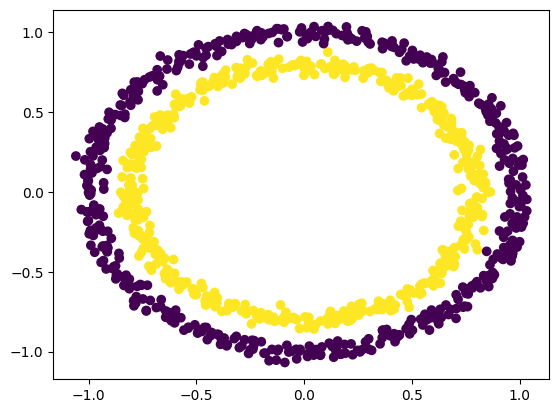

In [129]:
from matplotlib import pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y)

## 1.1 Turn Data into Tensors and Create Train & Test Splits

In [130]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split data into training and tests sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Building a Model

To do so, we want to:

1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one 
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [131]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses nn.Module (almost all models in PyTorch subclass nn.Module)
2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data
3. Defines a forward() method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target device

In [132]:
# 1. Construct a model that subclasses nn.Module
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.input_layer = nn.Linear(in_features=2,
                                 out_features=64,
                                 bias=True) # takes in 2 features and upscales to 64 features 
    
    self.first_hidden_layer = nn.Linear(in_features=64, 
                                  out_features=1,
                                  bias=True) # takes in 64 features from previous layer and outputs a single feature (same shape as y)
  
  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.first_hidden_layer(self.input_layer(x)) # x -> input_layer ->  first_hidden_layer -> output
  
# 4. Instantiate an instance of our model class and send it to the target device
model = CircleModel().to(device)
model

CircleModel(
  (input_layer): Linear(in_features=2, out_features=64, bias=True)
  (first_hidden_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [133]:
# Let's replicate the model above using nn.Sequential()
sequential_model = nn.Sequential(
    nn.Linear(in_features=2, out_features=64, bias=True),
    nn.Linear(in_features=64, out_features=1, bias=True)
).to(device)

sequential_model

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=1, bias=True)
)

In [134]:
# Setup the Loss Function and Optimizer
loss_func = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

In [135]:
# Evaluation Function
def accuracy_func(y_pred, y_true):
  correct = torch.eq(y_true, y_pred).sum().item()
  return ((correct/len(y_true))*100)

## 3. Build a Train & Test Loop

In [136]:
# torch.cuda.manual_seed(42)
torch.manual_seed(42)
epochs = 100

for epoch in range(epochs):
  # Train Mode
  model.train()

  # 1. Forward Pass
  train_logits = model.forward(X_train).squeeze()
  train_pred = torch.round(torch.sigmoid(train_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate Train Loss/Accuracy
  train_loss = loss_func(train_logits, y_train)
  train_accuracy = accuracy_func(train_pred, y_train)

  # 3. Zero Grad with Optimizer
  optimizer.zero_grad()

  # 4. Backpropagation with Loss
  train_loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  # Test Mode
  model.eval()
  with torch.inference_mode():
    # 1. Farward Pass
    test_logits = model.forward(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate Test Loss/Accuracy
    test_loss = loss_func(test_logits, y_test)
    test_accuracy = accuracy_func(test_pred, y_test)

  if epoch % 5 == 0:
    print(f'Epoch: {epoch} | Training Accuracy {train_accuracy:.2f} | Training Loss: {train_loss:.2f} | Testing Accuracy {test_accuracy:.2f} | Testing Loss: {test_loss:.2f}')

Epoch: 0 | Training Accuracy 52.50 | Training Loss: 0.73 | Testing Accuracy 47.50 | Testing Loss: 0.75
Epoch: 5 | Training Accuracy 52.62 | Training Loss: 0.72 | Testing Accuracy 48.50 | Testing Loss: 0.75
Epoch: 10 | Training Accuracy 52.50 | Training Loss: 0.72 | Testing Accuracy 48.00 | Testing Loss: 0.74
Epoch: 15 | Training Accuracy 52.38 | Training Loss: 0.71 | Testing Accuracy 47.00 | Testing Loss: 0.74
Epoch: 20 | Training Accuracy 52.00 | Training Loss: 0.71 | Testing Accuracy 47.00 | Testing Loss: 0.73
Epoch: 25 | Training Accuracy 52.12 | Training Loss: 0.71 | Testing Accuracy 47.00 | Testing Loss: 0.73
Epoch: 30 | Training Accuracy 52.38 | Training Loss: 0.71 | Testing Accuracy 47.50 | Testing Loss: 0.72
Epoch: 35 | Training Accuracy 51.88 | Training Loss: 0.71 | Testing Accuracy 47.50 | Testing Loss: 0.72
Epoch: 40 | Training Accuracy 51.75 | Training Loss: 0.70 | Testing Accuracy 48.00 | Testing Loss: 0.72
Epoch: 45 | Training Accuracy 51.62 | Training Loss: 0.70 | Testin

## From the metrics it looks like our model isn't learning anything...

In [137]:
import requests
from pathlib import Path

# Download helper functions
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/UygarKAYA/DeepLearning/main/helper_functions.py?token=GHSAT0AAAAAAB4RI7LG2HPTVAOWD6R7AKEUZB4D2EA")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


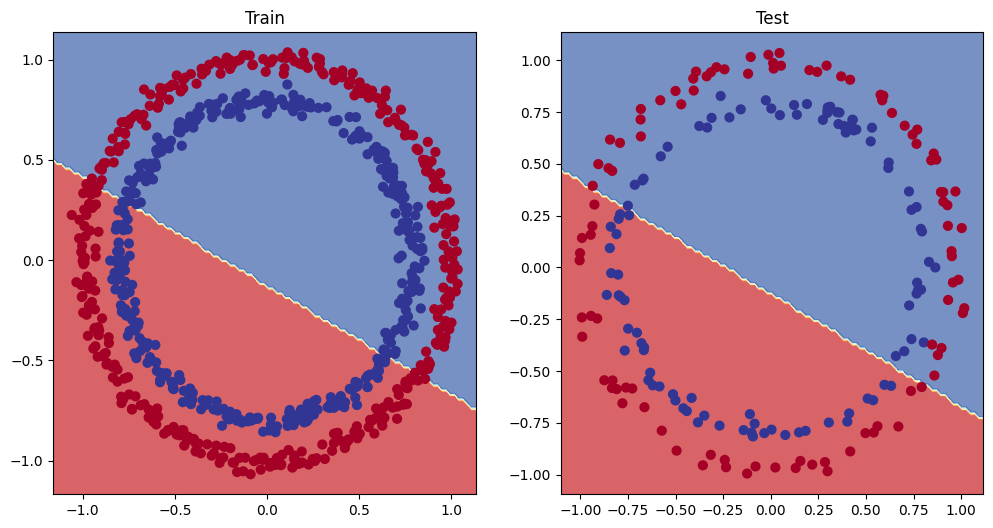

In [138]:
from helper_functions import plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test) 

## 4. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the * data 
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer 
* Changing the activation functions 
* Change the learning rate 
* Change the loss function


In [139]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_layer = nn.Linear(in_features=2, out_features=10)
    self.first_hidden_layer = nn.Linear(in_features=10, out_features=10)
    self.second_hidden_layer = nn.Linear(in_features=10, out_features=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.second_hidden_layer(self.first_hidden_layer(self.input_layer(x)))

improvedModel = CircleModelV1().to(device)
improvedModel

CircleModelV1(
  (input_layer): Linear(in_features=2, out_features=10, bias=True)
  (first_hidden_layer): Linear(in_features=10, out_features=10, bias=True)
  (second_hidden_layer): Linear(in_features=10, out_features=1, bias=True)
)

In [140]:
# Create a Loss Function
loss_func = nn.BCEWithLogitsLoss()
# Create a Optimizer
optimizer = torch.optim.SGD(params=improvedModel.parameters(),
                            lr=0.001)

In [141]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 250
for epoch in range(epochs):
  # Training Step
  improvedModel.train()

  train_logits = improvedModel.forward(X_train).squeeze()
  train_prediction = torch.round(torch.sigmoid(train_logits))

  train_loss = loss_func(train_logits, y_train)
  train_accuracy = accuracy_func(train_prediction, y_train)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()

  # Testing Step
  improvedModel.eval()
  with torch.inference_mode():
    test_logits = improvedModel.forward(X_test).squeeze()
    test_predictions = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_func(test_logits, y_test)
    test_accuracy = accuracy_func(test_predictions, y_test)
  
  if epoch % 25 == 0:
    print(f'Epoch: {epoch} | Training Accuracy {train_accuracy:.2f} | Training Loss: {train_loss:.2f} | Testing Accuracy {test_accuracy:.2f} | Testing Loss: {test_loss:.2f}')

Epoch: 0 | Training Accuracy 50.88 | Training Loss: 0.69 | Testing Accuracy 51.00 | Testing Loss: 0.69
Epoch: 25 | Training Accuracy 50.75 | Training Loss: 0.69 | Testing Accuracy 51.00 | Testing Loss: 0.69
Epoch: 50 | Training Accuracy 50.75 | Training Loss: 0.69 | Testing Accuracy 51.00 | Testing Loss: 0.69
Epoch: 75 | Training Accuracy 50.62 | Training Loss: 0.69 | Testing Accuracy 51.00 | Testing Loss: 0.69
Epoch: 100 | Training Accuracy 50.50 | Training Loss: 0.69 | Testing Accuracy 51.00 | Testing Loss: 0.69
Epoch: 125 | Training Accuracy 50.62 | Training Loss: 0.69 | Testing Accuracy 51.00 | Testing Loss: 0.69
Epoch: 150 | Training Accuracy 50.62 | Training Loss: 0.69 | Testing Accuracy 50.50 | Testing Loss: 0.69
Epoch: 175 | Training Accuracy 50.62 | Training Loss: 0.69 | Testing Accuracy 50.50 | Testing Loss: 0.69
Epoch: 200 | Training Accuracy 50.62 | Training Loss: 0.69 | Testing Accuracy 50.50 | Testing Loss: 0.69
Epoch: 225 | Training Accuracy 50.62 | Training Loss: 0.69 |

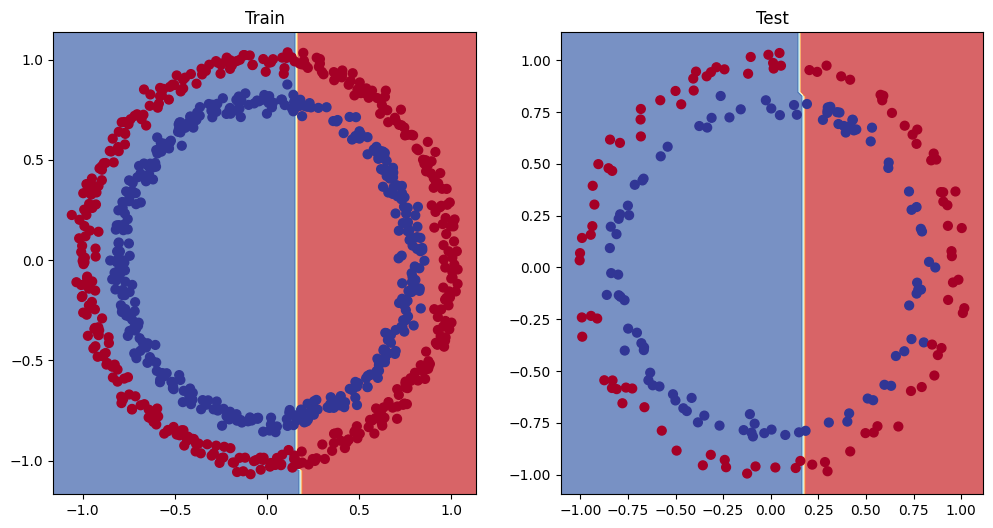

In [142]:
from helper_functions import plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(improvedModel, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(improvedModel, X_test, y_test) 

## 4.1 The missing piece: non-linearity
### 4.1.1 Building a model with non-linearity

In [143]:
# Build a model with non-linear activation functions

class NonLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_layer = nn.Linear(in_features=2, out_features=10)
    self.first_hidden_layer = nn.Linear(in_features=10, out_features=10)
    self.second_hidden_layer = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.second_hidden_layer(self.relu(self.first_hidden_layer(self.relu(self.input_layer(x)))))

improvedModelV1 = NonLinearModel().to(device)
improvedModelV1

NonLinearModel(
  (input_layer): Linear(in_features=2, out_features=10, bias=True)
  (first_hidden_layer): Linear(in_features=10, out_features=10, bias=True)
  (second_hidden_layer): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [144]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=improvedModelV1.parameters(),
                            lr=0.01)

In [145]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 250
for epoch in range(epochs):
  # Training Step
  improvedModelV1.train()

  train_logits = improvedModelV1.forward(X_train).squeeze()
  train_prediction = torch.round(torch.sigmoid(train_logits))

  train_loss = loss_func(train_logits, y_train)
  train_accuracy = accuracy_func(train_prediction, y_train)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()

  # Testing Step
  improvedModelV1.eval()
  with torch.inference_mode():
    test_logits = improvedModelV1.forward(X_test).squeeze()
    test_predictions = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_func(test_logits, y_test)
    test_accuracy = accuracy_func(test_predictions, y_test)
  
  if epoch % 25 == 0:
    print(f'Epoch: {epoch} | Training Accuracy {train_accuracy:.2f} | Training Loss: {train_loss:.2f} | Testing Accuracy {test_accuracy:.2f} | Testing Loss: {test_loss:.2f}')

Epoch: 0 | Training Accuracy 50.00 | Training Loss: 0.69 | Testing Accuracy 50.00 | Testing Loss: 0.69
Epoch: 25 | Training Accuracy 50.00 | Training Loss: 0.69 | Testing Accuracy 50.00 | Testing Loss: 0.69
Epoch: 50 | Training Accuracy 50.00 | Training Loss: 0.69 | Testing Accuracy 50.00 | Testing Loss: 0.69
Epoch: 75 | Training Accuracy 50.00 | Training Loss: 0.69 | Testing Accuracy 50.00 | Testing Loss: 0.69
Epoch: 100 | Training Accuracy 50.38 | Training Loss: 0.69 | Testing Accuracy 50.00 | Testing Loss: 0.69
Epoch: 125 | Training Accuracy 51.62 | Training Loss: 0.69 | Testing Accuracy 50.00 | Testing Loss: 0.69
Epoch: 150 | Training Accuracy 53.87 | Training Loss: 0.69 | Testing Accuracy 50.50 | Testing Loss: 0.69
Epoch: 175 | Training Accuracy 56.62 | Training Loss: 0.69 | Testing Accuracy 52.00 | Testing Loss: 0.69
Epoch: 200 | Training Accuracy 59.00 | Training Loss: 0.69 | Testing Accuracy 56.00 | Testing Loss: 0.69
Epoch: 225 | Training Accuracy 61.25 | Training Loss: 0.69 |

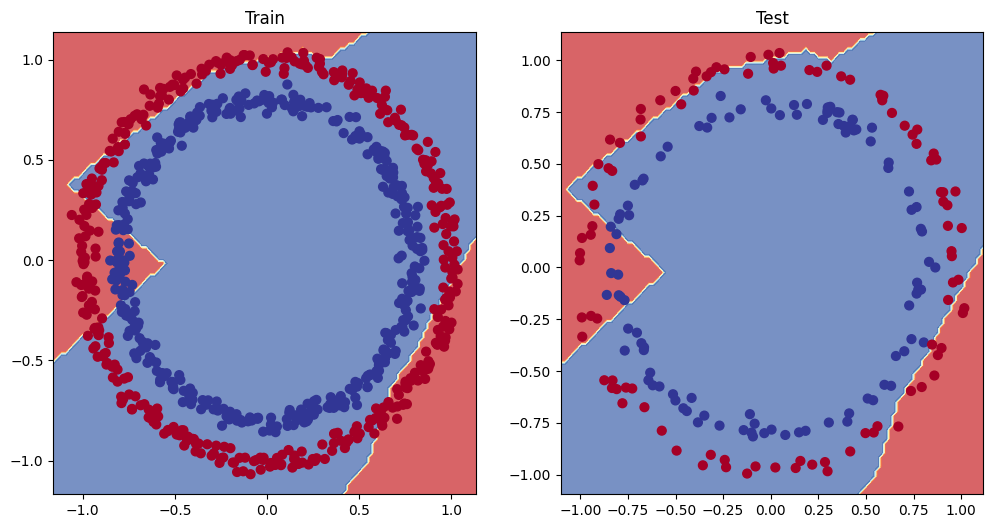

In [146]:
from helper_functions import plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(improvedModelV1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(improvedModelV1, X_test, y_test) 